# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop.](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения

Вам нужно реализовать свой фреймворк, [алгоритм обратного распространения ошибки](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BE%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B8), а также.

Зачем это нужно, когда есть сотни фреймворков, которые сами считают градиенты за нас?

Единственый способ проверить, что всё понимаешь — это закодить.

Один раз в жизни это нужно сделать.

Суть первой домашки — написать полноценную нейросеть чисто на numpy. 

Дизайн вдохновлен Torch-ем. Во всех современных eager-execution фреймворках примерно такой же интерфейс.

Это нужно сделать ровно один раз в жизни — чтобы понять, как это работает изнутри. Через неделю уже будем использовать фреймворки, которые это всё считают за нас.

* Проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy
* Обсуждайте решение, но не шарьте друг другу код — так не интересно

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

Откройте в Jupyter две тетрадки — эту и `hw_modules.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать. Там есть комменты — они облегчат вам задачу.

* Каждый модуль должен **возвращать** и **хранить** `output` и `gradInput`
* Считайте, что `module.backward` всегда выполняется после `module.forward`, который сохранит в себе `output`

Аналогично языковой модели с отбора, если придумаете какой-то более клёвый дизайн — вы вольны использовать его.

In [ ]:
%run hw_modules.ipynb

Вот вам немного уродливая имплементация SGD. Она нужна чисто для того, чтобы показать, как хранить состояние оптимизации.

In [2]:
def sgd_momentum(x, dx, config, state):
    """
        config — это
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x, dx): 
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out=cur_old_grad)
            cur_x -= cur_old_grad
            i += 1     

# Игрушечный пример

Начнем с логистической регрессии на синтезированных данных.

В этой секции ничего менять не надо — она нужна, чтобы отдебажить ваши слои в `hw_modules`.

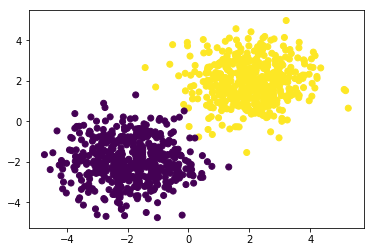

In [3]:
N = 500

X1 = np.random.randn(N, 2) + np.array([2, 2])
X2 = np.random.randn(N, 2) + np.array([-2, -2])
X = np.vstack([X1,X2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

plt.scatter(X[:,0],X[:,1], c = Y[:,0])
plt.show()

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой и софтмакс.

In [ ]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = ClassNLLCriterion()

print(net)

In [ ]:
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

n_epoch = 20
batch_size = 128

In [ ]:
def get_batches(dataset, batch_size):
    'Эта функция позволит итерироваться по датасету.'
    
    X, Y = dataset
    n_samples = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Обучение

Простой цикл обучения. Очень важно его осознать.

In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        net.zeroGradParameters()
        
        # forward — считаем все значения до функции потерь
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # backward — считаем все градиенты в обратном порядке
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # обновляем веса
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(loss_history, 'b')
plt.show()

# Теперь сами

[MNIST](http://yann.lecun.com/exdb/mnist/) — это как дрозофилы в эволюционной биологии или коты в квантовой физике. 

Стандартный датасет для классификации, на котором все всё тестируют.

In [ ]:
import os
from sklearn.datasets import fetch_mldata
# эти библиотеки нужны только для того, чтобы его скачать

if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X = mnist.data / 255.0 # очень важно его отнормировать
    y = mnist.target
    np.savez('mnist.npz', X=X, y=y)

Переведите лейблы в one-hot.

In [ ]:
# your code goes here

Разделите датасет на train и validation.

In [ ]:
# your code goes here

Теперь напишите модель и train loop. Можете начать адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* Поиграйтесь с архитектурами
* Поиграйтесь с learning rate и batch_size
* Сделайте learning rate decay
* Сделайте data augmentation

In [ ]:
# your code goes here

Выведите точность. Она должна быть около 90%.

In [ ]:
# your code goes here